In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

NO_ROBOTS = 6
ROBOT_RANGE = range(NO_ROBOTS)
NO_ROWS = 1000  # Limit window to be analysed
X_AXES = np.arange(NO_ROWS)

CLEAN = "clean-processed.csv"
VANISH_50 = "vanish-0.5-imputed.csv"

ID_COL, X_COL, Y_COL, TH_COL = "id", "x", "y", "orientation"
COLS = [X_COL, Y_COL, TH_COL]
COLS_ALL = COLS + [ID_COL]


def format_data(filename: str, id: bool = True) -> pd.DataFrame:  # for all 6 robots
    data = pd.read_csv(filename)
    if id:
        return data[COLS_ALL]
    return data[COLS].iloc[:NO_ROWS]


CLEAN_FD = format_data(CLEAN)
VANISH_50_FD = format_data(VANISH_50)


def extract_robot(data: pd.DataFrame, id: int) -> pd.DataFrame:
    return data[data[ID_COL]==id].iloc[:NO_ROWS].drop(ID_COL, axis=1).reset_index(drop=True)


cleans   = [extract_robot(CLEAN_FD, id) for id in ROBOT_RANGE]
vanish_50s = [extract_robot(VANISH_50_FD, id) for id in ROBOT_RANGE]


def get_current_ax(axs: np.ndarray, id: int) -> plt.Axes:
    return axs[id//3][id%3]

In [18]:
# Data cleaning utilities:

# 1. Turn timestamps into a rank.
# DATA_IN = "vanish-0.5-raw.csv"
# TS = 'ts'
# TS_NEW = 'ts-new'
# DATA_OUT = "vanish-0.5-processed.csv"

# data_in = pd.read_csv(DATA_IN)
# data_in[TS_NEW] = data_in[TS].rank(method='dense').astype(int)
# data_in.drop(TS, axis=1, inplace=True)
# data_out = data_in.iloc[:, [5, 0, 1, 2, 3, 4]]
# data_out.rename(columns={TS_NEW: TS}, inplace=True)
# data_out.to_csv(DATA_OUT, index=False)

# 2. Fill in data that vanished
CLEAN = "clean-processed.csv"
VANISH = "vanish-0.5-processed.csv"
OUTPUT = "vanish-0.5-imputed.csv"
imputation = {
    'color': 'yellow',
    'x': 0,
    'y': 0,
    'orientation': 0
}

clean = pd.read_csv(CLEAN)
vanish = pd.read_csv(VANISH)

complete_index = pd.MultiIndex.from_frame(clean[['ts', 'id']])
vanish.set_index(['ts', 'id'], inplace=True)
vanish_new = vanish.reindex(complete_index)
vanish_new.fillna(value=imputation, inplace=True)
vanish_new.reset_index(inplace=True)
vanish_new.sort_values(by=['ts', 'id'], inplace=True)
vanish_new.to_csv(OUTPUT, index=False)

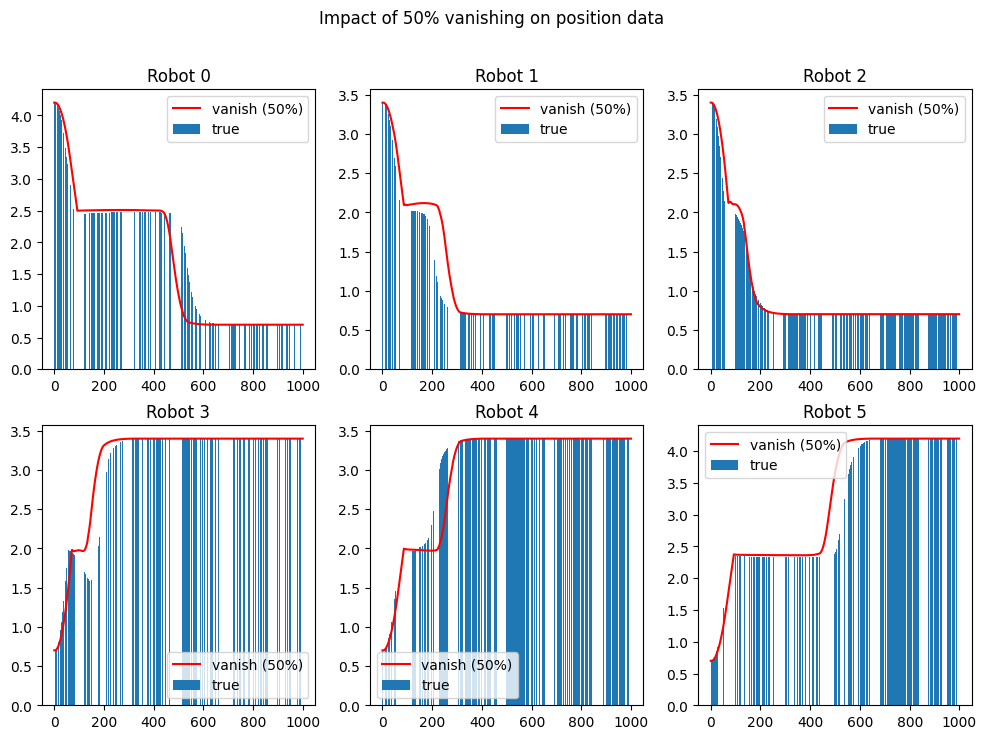

In [20]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Impact of 50% vanishing on position data")

for id in ROBOT_RANGE:
    clean = cleans[id]
    vanish_50 = vanish_50s[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.bar(X_AXES, vanish_50[X_COL])
    current_ax.plot(X_AXES, clean[X_COL], "r")
    
    current_ax.legend(("vanish (50%)", "true"))